## Imports

In [3]:
# Hidden depedency of geopandas: descartes
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pickle
import ipywidgets as widgets
from IPython.display import clear_output, display

# Data preparation for layout

## Layout dictionary

In [2]:
country_list = pickle.load(open('country_list.p', 'rb'))

In [3]:
country_dict = {}
for country in country_list:
    iso_code = country['ISO']
    if iso_code not in country_dict:
        country_dict[iso_code] = {
            'name': country['name'],
            'ISO': iso_code,
            'nr_parts': country['nr_parts'],
            'rows': 1,
            'cols': 1,
            'parts': [],
        }
    colroot = len(country_dict[iso_code]['parts'])
    country_dict[iso_code]['cols'] = colroot + 1
    country_dict[iso_code]['parts'].append({
        'name': country['name'],
        'main': country['main'],
        'geometry': country['geometry'],
        'rowroot': 0,
        'colroot': colroot,
        'rowspan': 1,
        'colspan': 1,
    })
pickle.dump(country_dict, open('country_dict.p', 'wb'))

## Manual Fixes

In [4]:
# Australia
try:
    country_dict['AUS']['parts'] = [country_dict['AUS']['parts'][0]]  # ignore small far away islands
    country_dict['AUS']['nr_parts'] = 1
    country_dict['AUS']['cols'] = 1
except KeyError:
    pass

# Chile
try:
    country_dict['CHL']['parts'] = country_dict['CHL']['parts'][:1]  # ignore small far away islands
    country_dict['CHL']['nr_parts'] = 1
    country_dict['CHL']['cols'] = 1
except KeyError:
    pass

# Costa Rica
try:
    country_dict['CRI']['parts'] = country_dict['CRI']['parts'][:1]  # ignore small far away islands
    country_dict['CRI']['nr_parts'] = 1
    country_dict['CRI']['cols'] = 1
except KeyError:
    pass

# France
try:
    parts_to_keep = {
        0,  # Mainland
        1,  # French Guinea
        2,  # New Caledonia
        6,  # Reunion Island
    }
    country_dict['FRA']['parts'] = [part for i, part in enumerate(country_dict['FRA']['parts']) if i in parts_to_keep]  # ignore small islands
    country_dict['FRA']['nr_parts'] = len(parts_to_keep)
    country_dict['FRA']['cols'] = len(parts_to_keep)
    colroot = 0
    for i in range(len(country_dict['FRA']['parts'])):
        country_dict['FRA']['parts'][i]['colroot'] = i
        i += 1
except KeyError:
    pass

# Mauritius
try:
    country_dict['MUS']['parts'] = country_dict['MUS']['parts'][:1]  # ignore far away islands
    country_dict['MUS']['nr_parts'] = 1
    country_dict['MUS']['cols'] = 1
except KeyError:
    pass

# New Zealand
try:
    country_dict['NZL']['parts'] = country_dict['NZL']['parts'][:1]  # ignore Cook Islands and Raoul Island
    country_dict['NZL']['nr_parts'] = 1
    country_dict['NZL']['cols'] = 1
except KeyError:
    pass

# Norway
try:
    country_dict['NOR']['parts'] = country_dict['NOR']['parts'][:1]  # ignore everything besides main part
    country_dict['NOR']['nr_parts'] = 1
    country_dict['NOR']['cols'] = 1
except KeyError:
    pass

# Portugal
try:
    country_dict['PRT']['parts'] = country_dict['PRT']['parts'][:-1]  # ignore Savage Islands
    country_dict['PRT']['nr_parts'] = 3
    country_dict['PRT']['cols'] = 3
except KeyError:
    pass

# Seychelles
try:
    country_dict['SYC']['parts'] = country_dict['SYC']['parts'][:1]  # ignore small islands
    country_dict['SYC']['nr_parts'] = 1
    country_dict['SYC']['cols'] = 1
except KeyError:
    pass

# South Africa
try:
    country_dict['ZAF']['parts'] = country_dict['ZAF']['parts'][:1]  # ignore small islands
    country_dict['ZAF']['nr_parts'] = 1
    country_dict['ZAF']['cols'] = 1
except KeyError:
    pass

# United States
try:
    country_dict['USA']['parts'] = country_dict['USA']['parts'][:4]  # ignore small islands
    country_dict['USA']['nr_parts'] = 4
    country_dict['USA']['cols'] = 4
except KeyError:
    pass

# United Kingdom
try:
    parts_to_keep = {
        0,  # Mainland
        1,  # Falkland Islands
        6,  # Cayman Islands
        7,  # Bermuda
    }
    country_dict['GBR']['parts'] = [part for i, part in enumerate(country_dict['GBR']['parts']) if i in parts_to_keep]  # ignore small islands
    country_dict['GBR']['nr_parts'] = len(parts_to_keep)
    country_dict['GBR']['cols'] = len(parts_to_keep)
    for i in range(len(parts_to_keep)):
        country_dict['GBR']['parts'][i]['colroot'] = i
        i += 1
except KeyError:
    pass

pickle.dump(country_dict, open('country_dict.p', 'wb'))

# Country maps layouting

## Summary & Parameters & Data
This notebook allows for real time layouting of the annotated country parts. All changes are saved upon changing the parameters.

In [20]:
country_dict["USA"]['parts'][3]['name'] = 'Puerto Rico & US VI'

In [1]:
skip_single_geometry_countries = True

In [4]:
country_dict = pickle.load(open('country_dict.p', 'rb'))
country_list_layout = [v for v in country_dict.values()]
pickle.dump(country_list_layout, open('country_list_layout.p', 'wb'))

## Layouting widgets

In [5]:
# global variables
index = 0
ui = None
rows = None
cols = None
parts_btns = None
nav_hbox = None

# Navigation functions
def next_clicked(button):
    global index
    global country_list_layout
    while True:
        index += 1
        if index == len(country_list_layout):
            index = 0
        if country_list_layout[index]['nr_parts'] > 1 or not skip_single_geometry_countries:
            break
    clear_output(wait=True)
    setup_ui(index)
    draw_country(index)
    
def previous_clicked(button):
    global index
    global country_list_layout
    while True:
        index -= 1
        if index < 0:
            index = len(country_list_layout) - 1
        if country_list_layout[index]['nr_parts'] > 1 or not skip_single_geometry_countries:
            break
    clear_output(wait=True)
    setup_ui(index)
    draw_country(index)

# Navigation buttons
goto_next = widgets.Button(
    description='Next country',
    disabled=False,
    button_style='',
    tooltip='Next country',
    icon=''
)
goto_previous = widgets.Button(
    description='Previous country',
    disabled=False,
    button_style='',
    tooltip='Previous country',
    icon=''
)

# Naviation eventlisteners
goto_next.on_click(next_clicked)
goto_previous.on_click(previous_clicked)

# Navigation layout
nav_hbox = widgets.HBox([goto_previous, goto_next])

In [6]:
# This function creates all input elements for the country at the index. Navigation buttons are reused.
def setup_ui(index):
    global country_list_layout
    global ui
    global nav_hbox
    global rows
    global cols
    global parts_btns
    
    # Create UI elements
    # Total rows and cols inputs
    rows = widgets.IntText(
        value=country_list_layout[index]['rows'],
        description='Rows',
        layout=widgets.Layout(width='15%')
    )
    cols = widgets.IntText(
        value=country_list_layout[index]['cols'],
        description='Cols',
        layout=widgets.Layout(width='15%')
    )
    # For each country part, create rowroot, colroot, rowspan and colspan.
    parts_btns = []
    for p in country_list_layout[index]['parts']:
        parts_btns.append({
            'name': widgets.Label(
                value=p['name'],
                layout=widgets.Layout(width='15%')
            ),
            'rowroot':widgets.IntText(
                value=p['rowroot'],
                description='RRoot',
                layout=widgets.Layout(width='15%')
            ),
            'colroot':widgets.IntText(
                value=p['colroot'],
                description='CRoot',
                layout=widgets.Layout(width='15%')
            ),
            'rowspan':widgets.IntText(
                value=p['rowspan'],
                description='RSpan',
                layout=widgets.Layout(width='15%')
            ),
            'colspan':widgets.IntText(
                value=p['colspan'],
                description='CSpan',
                layout=widgets.Layout(width='15%')
            ),
        })
    # Assign UI eventlistener to all inputs
    for b in [rows, cols] + [btn for part_btns in parts_btns for btn in part_btns.values()]:
        b.observe(on_value_change, names='value')
    # Layout UI elements
    rows_cols_hbox = widgets.HBox([rows, cols])
    parts_btns_hboxes = []
    for p in parts_btns:
        parts_btns_hboxes.append(widgets.HBox(tuple(b for b in p.values())))
    ui = widgets.VBox(tuple([nav_hbox, rows_cols_hbox, *parts_btns_hboxes]))
    # Display UI
    display(ui)

# This function draws the country at the index using the parameters from the country list.
def draw_country(index):
    fig = plt.figure(figsize=(9.8, 5.25), frameon=True, facecolor="#f0f0ed")
    global country_list_layout
    rows = country_list_layout[index]['rows']
    cols = country_list_layout[index]['cols']
    for i, p in enumerate(country_list_layout[index]['parts']):
        ax = plt.subplot2grid(
            shape=(rows, cols), 
            loc=(p['rowroot'], p['colroot']),
            colspan=p['colspan'],
            rowspan=p['rowspan']
        )
        if country_list_layout[index]['ISO'] == "KIR":
            edgecolor = "black"
        else:
            edgecolor = None
        p['geometry'].plot(ax=ax, facecolor='#c7c7c4', edgecolor=edgecolor)
        plt.axis('equal')
        if i > 0 or country_list_layout[index]['ISO'] == "KIR":
            plt.xlabel(p['name'], fontsize=11, labelpad=0)
            ax.xaxis.set_major_formatter(NullFormatter())
            ax.xaxis.set_ticks_position('none')
            ax.yaxis.set_major_formatter(NullFormatter())
            ax.yaxis.set_ticks_position('none')
        else:
            ax.set_axis_off()
        ax.set_facecolor("#f0f0ed")
        fig.tight_layout()
        plt.subplots_adjust(hspace=0.5)
    plt.show();

# This function gets called each time a UI element is clicked (except for nav buttons).
# Updates and pickles list, sets up UI, draws country.
def on_value_change(change):
    global country_list_layout
    global index
    global rows
    global cols
    global parts_btns
    clear_output(wait=True)
    country_list_layout[index]['rows'] = rows.value
    country_list_layout[index]['cols'] = cols.value
    for i, part in enumerate(country_list_layout[index]['parts']):
        country_list_layout[index]['parts'][i]['rowroot'] = parts_btns[i]['rowroot'].value
        country_list_layout[index]['parts'][i]['colroot'] = parts_btns[i]['colroot'].value
        country_list_layout[index]['parts'][i]['rowspan'] = parts_btns[i]['rowspan'].value
        country_list_layout[index]['parts'][i]['colspan'] = parts_btns[i]['colspan'].value
    setup_ui(index)
    try:
        draw_country(index)
        pickle.dump(country_list_layout, open('country_list_layout.p', 'wb'))
    except:
        pass

## Real time layouting

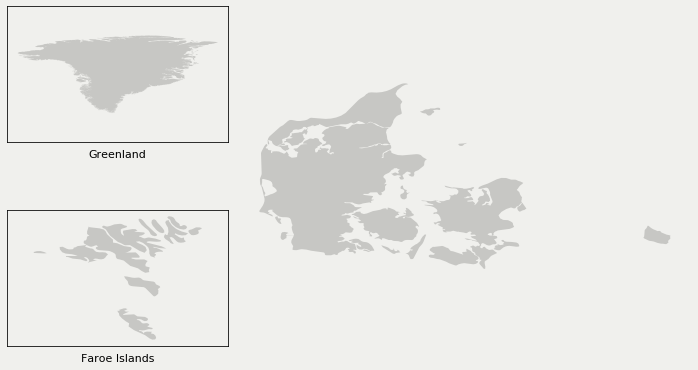

In [7]:
next_clicked(None)

## Save your work

Once you're done playing around with the widgets above, make sure to run the next cell to save your work.

In [21]:
for country in country_list_layout:
    iso_code = country['ISO']
    country_dict[iso_code] = country
pickle.dump(country_dict, open('country_dict.p', 'wb'))